### IMPORT LIBRARIES

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# evaluation metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

# scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# autoencoder
import tensorflow as tf
from tensorflow import keras

# deep learning
from keras.models import Model, Sequential
from keras import regularizers
from keras.layers import (
    Input,
    Conv1D,
    MaxPooling1D,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization,
)
from keras.optimizers import Adam

### LOADING DATASET

In [2]:
credit_card = pd.read_excel("card transactions.xlsx")

### DATA PREPROCESSING 

In [3]:
credit_card.shape

(96753, 10)

In [4]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96753 entries, 0 to 96752
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             96753 non-null  int64         
 1   Cardnum            96753 non-null  int64         
 2   Date               96753 non-null  datetime64[ns]
 3   Merchnum           93378 non-null  object        
 4   Merch description  96753 non-null  object        
 5   Merch state        95558 non-null  object        
 6   Merch zip          92097 non-null  float64       
 7   Transtype          96753 non-null  object        
 8   Amount             96753 non-null  float64       
 9   Fraud              96753 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 7.4+ MB


### EXTRACT DAY AND MONTH FOR FURTHER ANALYSIS

In [5]:
day =pd.to_datetime(credit_card['Date']).dt.dayofweek
month =pd.to_datetime(credit_card['Date']).dt.month
credit_card.insert(1, 'day', day)
credit_card.insert(2, 'month', month)
credit_card = credit_card.drop('Date', axis = 1)

In [6]:
dict_populated = {}
for i in credit_card.columns.to_list():
    dict_populated[i] = credit_card[i].count()/len(credit_card)*100
dict_populated

{'Recnum': 100.0,
 'day': 100.0,
 'month': 100.0,
 'Cardnum': 100.0,
 'Merchnum': 96.51173607019938,
 'Merch description': 100.0,
 'Merch state': 98.76489617892985,
 'Merch zip': 95.1877461163995,
 'Transtype': 100.0,
 'Amount': 100.0,
 'Fraud': 100.0}

### CHECKING FOR NULL VALUES

In [7]:
credit_card.isnull().sum()

Recnum                  0
day                     0
month                   0
Cardnum                 0
Merchnum             3375
Merch description       0
Merch state          1195
Merch zip            4656
Transtype               0
Amount                  0
Fraud                   0
dtype: int64

### DROPPING THE NULL VALUES

In [8]:
credit_card = credit_card.dropna()
credit_card

,Recnum,day,month,Cardnum,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,4,1,5142190439,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
1,2,4,1,5142183973,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0
2,3,4,1,5142131721,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0
3,4,4,1,5142148452,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0
4,5,4,1,5142190439,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
...,...,...,...,...,...,...,...,...,...,...,...
96748,96749,4,12,5142276053,3500000006160,BEST BUY 00001610,KY,41042.0,P,84.79,0
96749,96750,4,12,5142225701,8090710030950,MARKUS OFFICE SUPPLIES,OH,45248.0,P,118.75,0
96750,96751,4,12,5142226486,4503057341100,"TECH PAC, INC",OH,45150.0,P,363.56,0
96751,96752,4,12,5142244619,8834000695412,BUY.COM,CA,92656.0,P,2202.03,0


### UNIQUE VALUES

In [9]:
dict_unique = {}
for i in credit_card.columns.to_list():
    dict_unique[i]=len(credit_card[i].unique())
dict_unique

{'Recnum': 90198,
 'day': 7,
 'month': 12,
 'Cardnum': 1622,
 'Merchnum': 12807,
 'Merch description': 12184,
 'Merch state': 51,
 'Merch zip': 4452,
 'Transtype': 1,
 'Amount': 33878,
 'Fraud': 2}

### CHECKING FOR DUPLICATES

In [10]:
credit_card.duplicated().sum()

0

### STATISTICS SUMMARY

In [11]:
credit_card.describe()

,Recnum,day,month,Cardnum,Merch zip,Amount,Fraud
count,90198.000000,90198.000000,90198.000000,9.019800e+04,90198.000000,90198.000000,90198.000000
mean,48355.064835,2.571576,6.320063,5.142202e+09,44581.840872,397.266831,0.011331
std,27697.328106,2.109709,3.210985,5.589836e+04,28269.803688,816.286539,0.105841
min,1.000000,0.000000,1.000000,5.142110e+09,1.000000,0.010000,0.000000
25%,24550.250000,1.000000,4.000000,5.142151e+09,20854.000000,33.780000,0.000000
50%,48459.500000,2.000000,6.000000,5.142196e+09,38118.000000,139.000000,0.000000
75%,72101.750000,5.000000,9.000000,5.142245e+09,63103.000000,429.977500,0.000000
max,96753.000000,6.000000,12.000000,5.142847e+09,99999.000000,30372.460000,1.000000


### EXPLORING THE DATASET

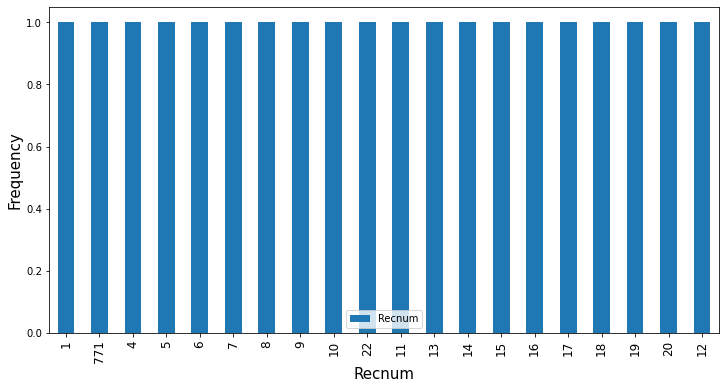

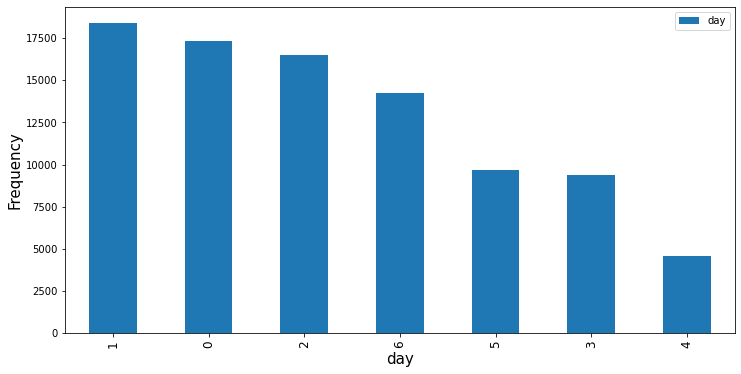

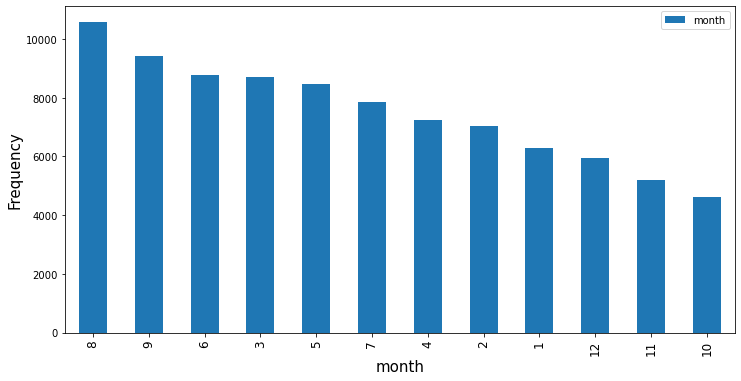

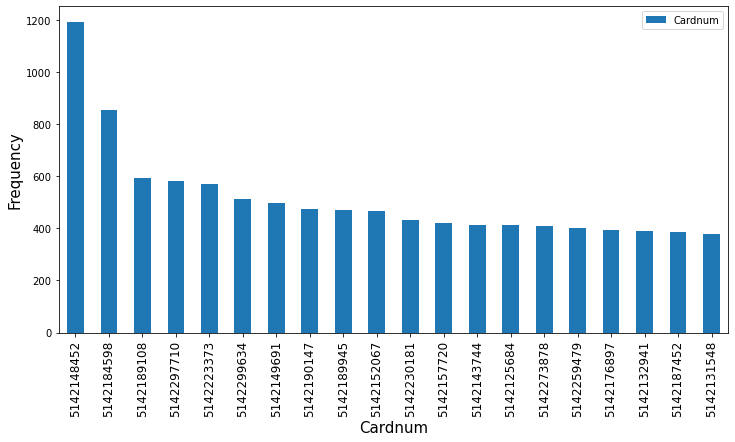

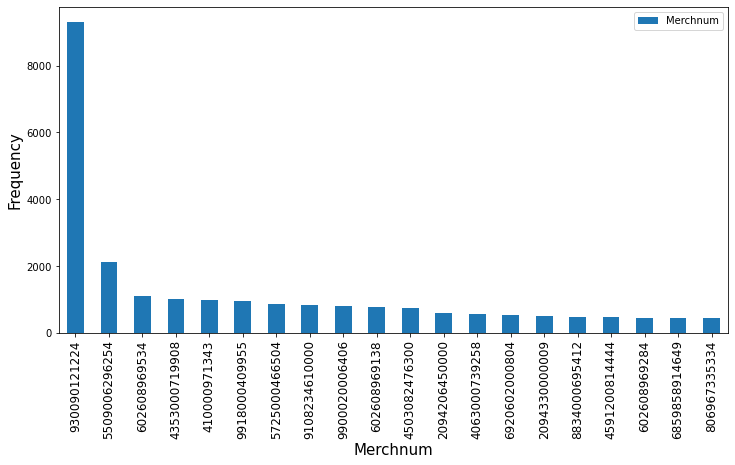

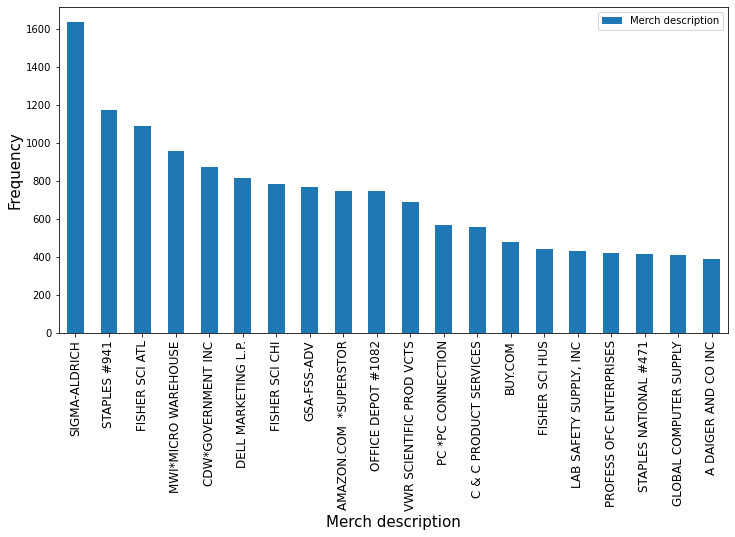

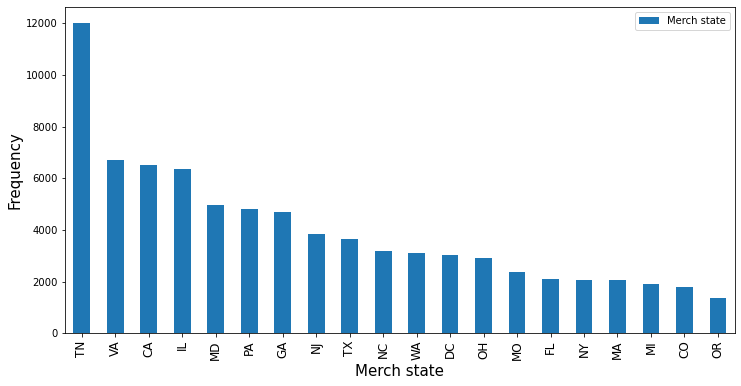

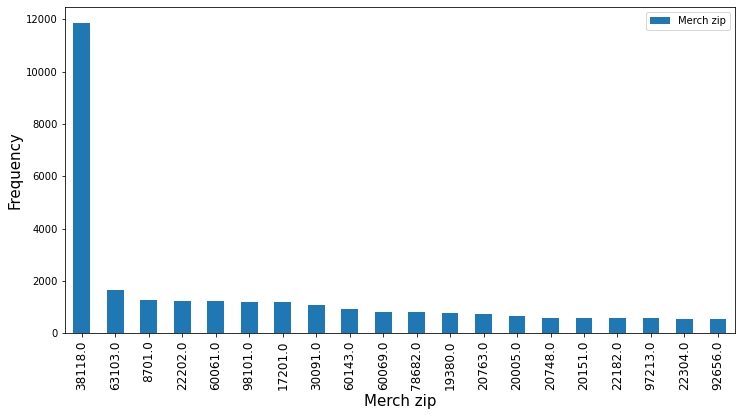

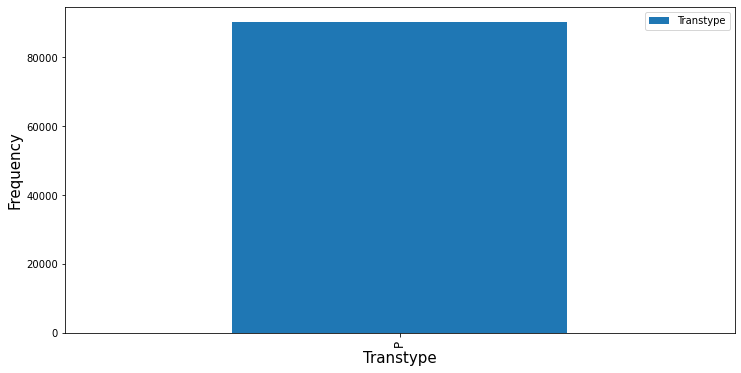

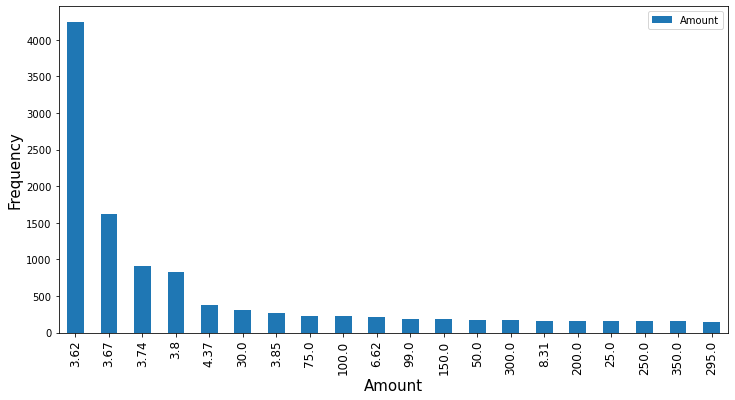

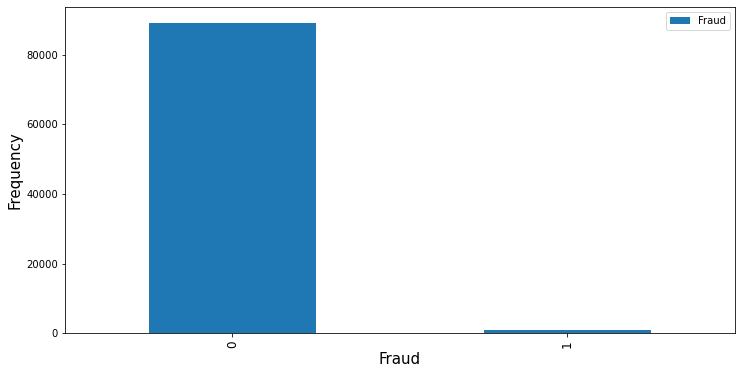

In [12]:
categoricalVar = credit_card.columns.tolist()
for col in categoricalVar:
    df = pd.DataFrame(credit_card[col].value_counts().sort_values(ascending=False).head(20))
    df.plot(kind='bar',figsize=(12,6))
    plt.xlabel(col,fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.xticks(fontsize=12)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Count')

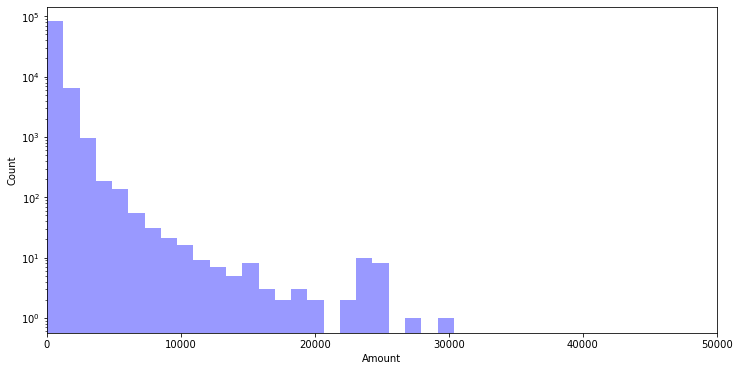

In [13]:
plt.rcParams["figure.figsize"] = [12,6]
xhigh = 50000
plt.xlim(0,xhigh)
temp = credit_card[credit_card['Amount'] <= xhigh]
sns.set_palette("deep")
plot=sns.distplot(temp['Amount'],bins=25, kde=False, color='blue')
plot.set_yscale('log')
plt.ylabel('Count')

Text(0.5, 0, 'Amount')

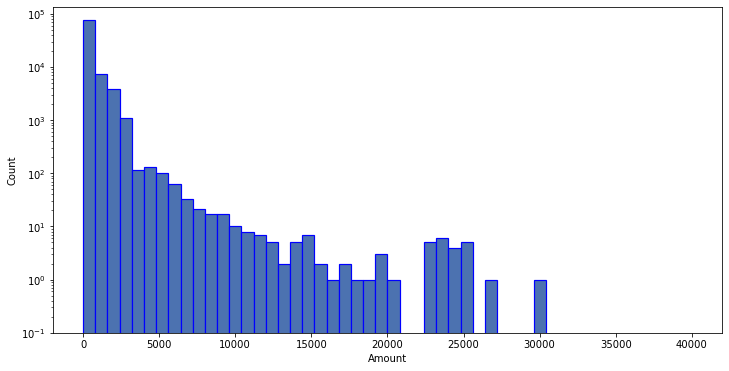

In [14]:
plt.hist(credit_card['Amount'],bins=50,range=[0,40000],edgecolor='blue',linewidth=1.2)
plt.yscale('log')
plt.ylim(bottom = .1)
plt.ylabel('Count')
plt.xlabel('Amount')

### CORRELATION ANALYSIS

In [15]:
credit_card_corr = credit_card.corr()['Fraud'].abs().sort_values(ascending=False)
credit_card_corr

Fraud        1.000000
Amount       0.217197
Cardnum      0.042390
month        0.037741
Recnum       0.037017
Merch zip    0.032984
day          0.014640
Name: Fraud, dtype: float64

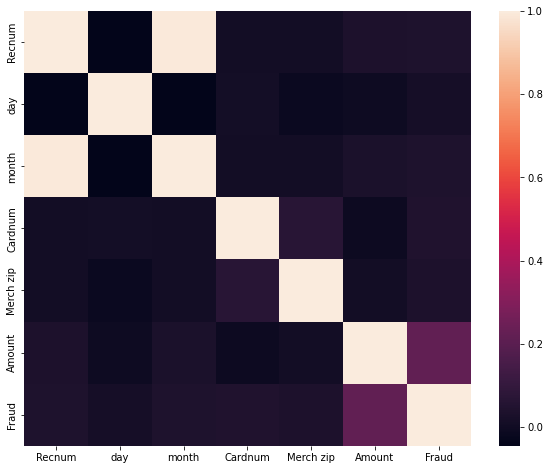

In [16]:
fig = plt.figure(figsize=(10, 8))
sns.heatmap(credit_card.corr())
plt.show()

The correlation plot shows no presence of multi collinearity amongst the features. All of these features does not show high correlation with the target class

### DISTRIBUTION OF TARGET CLASS

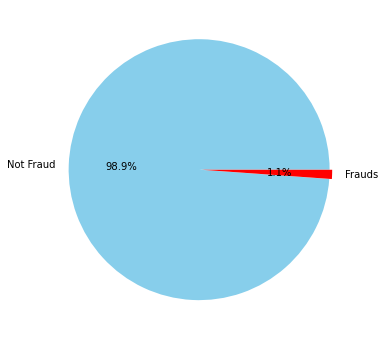

In [17]:
plt.figure(figsize=(10,6))
labels = ['Not Fraud' , 'Frauds']
explode = [.01,.01]
color = ['skyblue' , 'Red']
sizes = credit_card.Fraud.value_counts().values

plt.pie(sizes,explode,labels,autopct="%1.1f%%", colors = color)
plt.show()

The pie chart shows highly imbalanced dataset. 

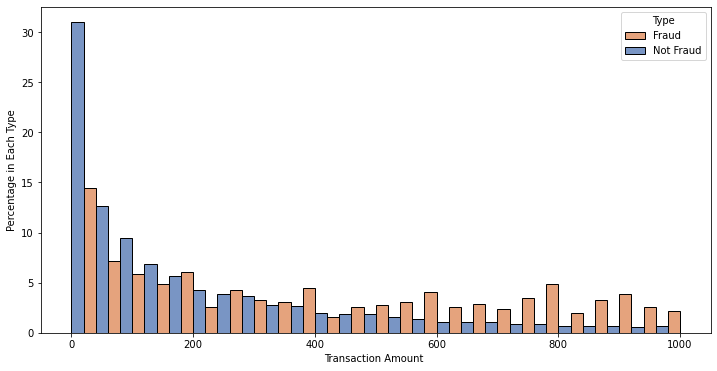

In [18]:
ax=sns.histplot(x='Amount',data=credit_card[credit_card.Amount<=1000],
                hue='Fraud',stat='percent',multiple='dodge',common_norm=False,bins=25)
ax.set_ylabel('Percentage in Each Type')
ax.set_xlabel('Transaction Amount ')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

### STATE VS FRAUD : let's also explore which geographies are more prone to fraud. 

Text(0.5, 1.0, 'The Percentage of Fraudulent over Non-Fraudulent Transcations in Each State')

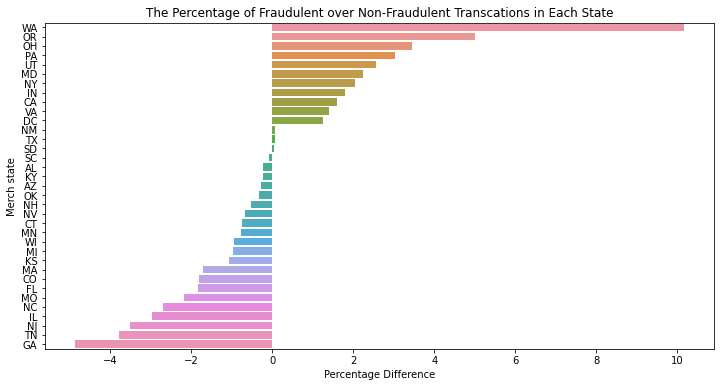

In [19]:
a=credit_card['Merch state'][credit_card.Fraud==0].value_counts(normalize=True)
a=a.to_frame()
a=a.reset_index()
a.columns = ['Merch state', 'Per']

b=credit_card['Merch state'][credit_card.Fraud==1].value_counts(normalize=True)
b=b.to_frame()
b=b.reset_index()
b.columns = ['Merch state', 'Per']

merged=a.merge(b,on='Merch state')
merged['diff']=merged['Per_y']-merged['Per_x']
merged['diff']=merged['diff']*100
merged=merged.sort_values('diff',ascending=False)

ax1=sns.barplot(data=merged, x='diff',y='Merch state')
ax1.set_xlabel('Percentage Difference')
ax1.set_ylabel('Merch state')
plt.title('The Percentage of Fraudulent over Non-Fraudulent Transcations in Each State')

### Monthly trends

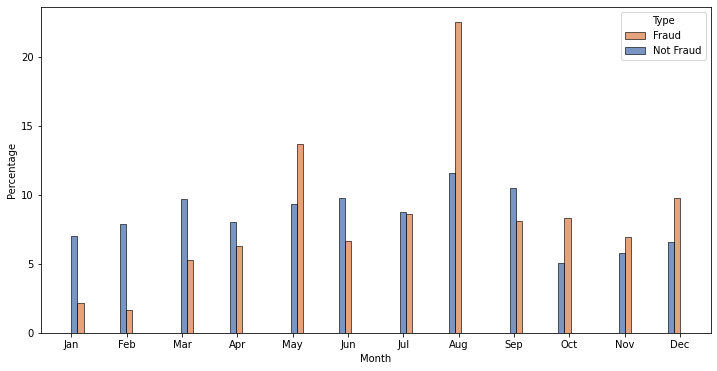

In [20]:
#month vs fraud
ax=sns.histplot(data=credit_card, x="month", hue="Fraud", common_norm=False,stat='percent',multiple='dodge')
ax.set_ylabel('Percentage')
ax.set_xlabel('Month')
plt.xticks(np.arange(1,13,1))
ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul",'Aug','Sep','Oct','Nov','Dec'])
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

### Daily trend

C:\Users\b1379039\AppData\Local\Temp\ipykernel_13936\3150562307.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['',"Mon","Tue","Wed","Thu","Fri","Sat","Sun"])


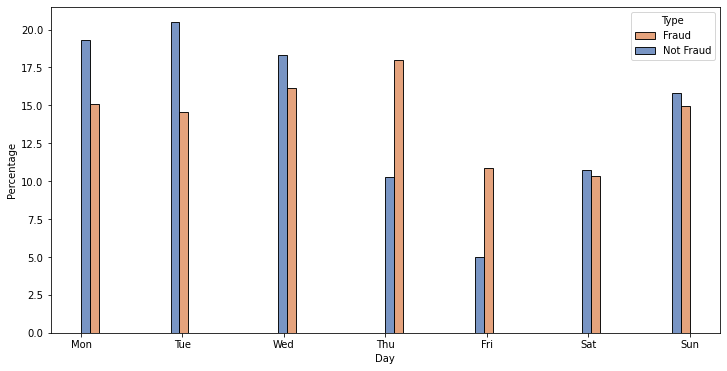

In [21]:
ax=sns.histplot(data = credit_card, x="day", hue="Fraud", common_norm=False,stat='percent',multiple='dodge')
ax.set_xticklabels(['',"Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
ax.set_ylabel('Percentage')
ax.set_xlabel('Day')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

### DATASET DISTRIBUTION AND A SIMPLE APPROACH OF UNDERSAMPLING

In [22]:
#First Method of solving this problem which comes in mind will be by 
#taking same number of records of the majority class as the minority class
credit_card = credit_card.drop(['Transtype'], axis=1)
fraud_data = credit_card.loc[credit_card["Fraud"] == 1]
non_fraud_data = credit_card.loc[credit_card["Fraud"] == 0][:1022]

#concating the above dataframes to get a single dataframe
normal_distributed_df = pd.concat([fraud_data, non_fraud_data])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)
# setting up separate dataframes for fraud and non_fraud data for detailed analysis and comparison

print("Fraud Data Shape: ", fraud_data.shape)
print("Non-Fraud Data Shape: ", non_fraud_data.shape)

Fraud Data Shape:  (1022, 10)
Non-Fraud Data Shape:  (1022, 10)


In [23]:
#Now we have exactly 50-50 percent rows of both majority and minority classes

print('No Frauds', round(new_df['Fraud'].value_counts()[0]/len(new_df) * 100 , 2), '% of the dataset')
print('Frauds', round(new_df['Fraud'].value_counts()[1]/len(new_df) * 100 , 2), '% of the dataset')

No Frauds 50.0 % of the dataset
Frauds 50.0 % of the dataset


### ENCODING INDEPENDENT VARIABLE

In [24]:
le = LabelEncoder()
new_df["Merchnum"] = le.fit_transform(new_df['Merchnum'])
new_df["Merch description"] = le.fit_transform(new_df['Merch description'])
new_df["Merch state"] = le.fit_transform(new_df['Merch state'])
new_df

,Recnum,day,month,Cardnum,Merchnum,Merch description,Merch state,Merch zip,Amount,Fraud
41695,41696,5,6,5142111125,632,116,31,44103.0,4279.34,1
299,300,0,1,5142178227,371,527,12,60603.0,33.66,0
50319,50320,6,7,5142176939,177,496,17,20763.0,1346.62,1
59817,59818,2,8,5142138135,626,388,30,12202.0,7360.42,1
571,572,1,1,5142144134,651,648,41,22314.0,19.97,0
...,...,...,...,...,...,...,...,...,...,...
133,134,6,1,5142260984,163,505,41,22041.0,15.98,0
311,312,0,1,5142189945,598,112,3,92656.0,5112.19,0
87460,87461,1,11,5142206786,250,138,41,22039.0,116.00,1
485,486,1,1,5142130323,81,559,41,22304.0,131.80,0


### FEATURE SCALING THE DATASET 

In [25]:
#standardize the independent variables of the dataset 
#after scaling -1.0 means 0 and 1 remains 1 
from sklearn.preprocessing import MinMaxScaler,RobustScaler
df = pd.DataFrame(StandardScaler().fit_transform(new_df), columns=new_df.columns, index=new_df.index)
df

,Recnum,day,month,Cardnum,Merchnum,Merch description,Merch state,Merch zip,Amount,Fraud
41695,0.373921,1.280883,0.468455,-0.934997,1.227079,-1.163108,0.358556,-0.138674,1.322675,1.0
299,-0.869619,-1.215423,-0.851901,-0.300915,0.009823,0.733899,-1.062205,0.393393,-0.513138,-1.0
50319,0.632987,1.780145,0.732526,-0.313086,-0.894957,0.590816,-0.688321,-0.891307,0.054580,1.0
59817,0.918308,-0.216900,0.996597,-0.679765,1.199096,0.092332,0.283779,-1.167370,2.654921,1.0
571,-0.861448,-0.716161,-0.851901,-0.623078,1.315691,1.292385,1.106325,-0.841293,-0.519058,-1.0
...,...,...,...,...,...,...,...,...,...,...
133,-0.874605,1.780145,-0.851901,0.481099,-0.960251,0.632356,1.106325,-0.850096,-0.520783,-1.0
311,-0.869258,-1.215423,-0.851901,-0.190186,1.068509,-1.181570,-1.735198,1.426989,1.682796,-1.0
87460,1.748706,-0.716161,1.788810,-0.031046,-0.554499,-1.061565,1.106325,-0.850161,-0.477535,1.0
485,-0.864031,-0.716161,-0.851901,-0.753585,-1.342684,0.881598,1.106325,-0.841616,-0.470703,-1.0


In [26]:
#splitting the dataset
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

X_train = X_train[X_train.Fraud == -1.0]
X_train = X_train.drop(['Fraud'], axis=1)

y_test = X_test['Fraud']
X_test = X_test.drop(['Fraud'], axis=1)

X_train = X_train
X_test = X_test
X_train.shape
X_test.shape

(409, 9)

### UNDERCOMPLETE AUTOENCODER

The Autoencoder model for anomaly detection has some steps as follows: 

Step 1 is the encoder step. The essential information is extracted by a neural network model in this step.

Step 2 is the decoder step. In this step, the model reconstructs the data using the extracted information.

Step 3: Iterate step 1 and step 2 to adjust the model to minimize the difference between input and reconstructed output, until we get good reconstruction results for the training dataset.

Step 4: Make predictions on a dataset that includes outliers.

Step 5: Set up a threshold for outliers/anomalies by comparing the differences between the autoencoder model reconstruction value and the actual value.

Step 6: Identify the data points with the difference higher than the threshold to be outliers or anomalies.

#### INPUT LAYER

In [27]:
# 'tanh' is used for the activation function of the encoded network 
# because it has big learning steps and results in strong or higher gradients

#relu is used on the bottle neck (latent low representation) 
#because model performance is better when trained with relu

#sigmoid is used for binary classification and since we have 
#fraud and non fraudclass then it is good for this problem

#In the input layer, we specified the shape of the dataset. 


input_layer = Input(shape=(X_train.shape[1],))

#### BUILDING THE ENCODER NETWORK

In [28]:

#Note that the encoder requires the number of neurons to decrease with the layers. 
#The last layer in the encoder is the size of the encoded representation, and it is also called the bottleneck.
encoded = Dense(512, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(256, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(encoded)
encoded = Dense(128, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(encoded)
encoded = Dense(64, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(encoded)
encoded = Dense(2, activation="relu")(encoded)

In [29]:
#Opposite from the encoder, the decoder requires the number of neurons to increase with the layers. 
#The output layer in the decoder has the same size as the input layer.

decoded = Dense(64, activation="tanh")(encoded)
decoded = Dense(128, activation="tanh")(decoded)
decoded = Dense(256, activation="tanh")(decoded)
decoded = Dense(512, activation="tanh")(decoded)

In [30]:
output_layer = Dense(X_train.shape[1], activation="sigmoid")(decoded)

#### MODEL CREATION

In [31]:
#After defining the input, encoder, and decoder layers, we create the autoencoder model to combine the layers.
autoencoder = Model(input_layer, output_layer)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense (Dense)               (None, 512)               5120      
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 2)                 130       
                                                                 
 dense_5 (Dense)             (None, 64)                192   

In [32]:
# compiling the auto encoder model  with the optimizer of adam and the loss of mse (Mean squared Error).
autoencoder.compile(optimizer="adam", loss="mse")

#When fitting the autoencoder model, we can see that the input and output datasets are the same,
#which is the dataset that contains only the normal data points.

#The epochs of 50 and batch_size of 32 mean the model uses 32 datapoints to update the weights in each iteration, 
#and the model will go through the whole training dataset 50 times.

#shuffle=True will shuffle the dataset before each epoch.

# training the auto encoder model on non fraud data 
history = autoencoder.fit(X_train, X_train,batch_size=32,epochs=50,shuffle=True,validation_data=(X_test, X_test))

Epoch 1/50
26/26 [==============================] - 1s 13ms/step - loss: 0.8818 - val_loss: 0.9835
Epoch 2/50
26/26 [==============================] - 0s 5ms/step - loss: 0.7381 - val_loss: 0.9675
Epoch 3/50
26/26 [==============================] - 0s 5ms/step - loss: 0.6930 - val_loss: 0.9368
Epoch 4/50
26/26 [==============================] - 0s 5ms/step - loss: 0.6786 - val_loss: 0.9499
Epoch 5/50
26/26 [==============================] - 0s 5ms/step - loss: 0.6739 - val_loss: 0.9561
Epoch 6/50
26/26 [==============================] - 0s 4ms/step - loss: 0.6710 - val_loss: 0.9578
Epoch 7/50
26/26 [==============================] - 0s 5ms/step - loss: 0.6694 - val_loss: 0.9642
Epoch 8/50
26/26 [==============================] - 0s 4ms/step - loss: 0.6674 - val_loss: 0.9678
Epoch 9/50
26/26 [==============================] - 0s 5ms/step - loss: 0.6655 - val_loss: 0.9689
Epoch 10/50
26/26 [==============================] - 0s 4ms/step - loss: 0.6647 - val_loss: 0.9653
Epoch 11/50
26/26 

Text(0.5, 1.0, 'Loss Curves')

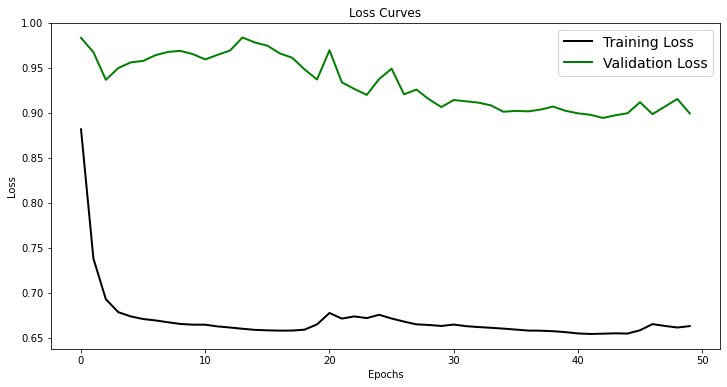

In [33]:
# Loss curve

plt.plot(history.history["loss"], "black", linewidth=2.0)
plt.plot(history.history["val_loss"], "green", linewidth=2.0)
plt.legend(["Training Loss", "Validation Loss"], fontsize=14)
plt.xlabel("Epochs", fontsize=10)
plt.ylabel("Loss", fontsize=10)
plt.title("Loss Curves", fontsize=12)

This chart visualizes the training and validation loss changes during the model fitting. The x-axis is the number of epochs, and the y axis is the loss. We can see that both training and validation losses decrease with the increase of epochs.

In [34]:
#we have an autoencoder model, let's use it to predict the outliers.
#Firstly, we use .predict to get the reconstruction value for the testing data 
#set containing the usual data points and the outliers.


# Predict anomalies/outliers in the training dataset
prediction = autoencoder.predict(X_test)

13/13 [==============================] - 0s 1ms/step


In [35]:
mse = np.mean(np.power(X_test - prediction, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [36]:
error_df.describe()

,reconstruction_error,true_class
count,409.000000,409.000000
mean,0.887453,-0.017115
std,0.770553,1.001078
min,0.195117,-1.000000
25%,0.485285,-1.000000
50%,0.699621,-1.000000
75%,0.964843,1.000000
max,4.581585,1.000000


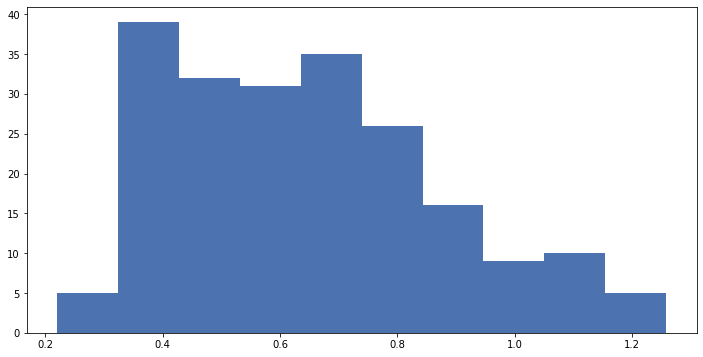

In [44]:
#Reconstruction error without fraud
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== -1.0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

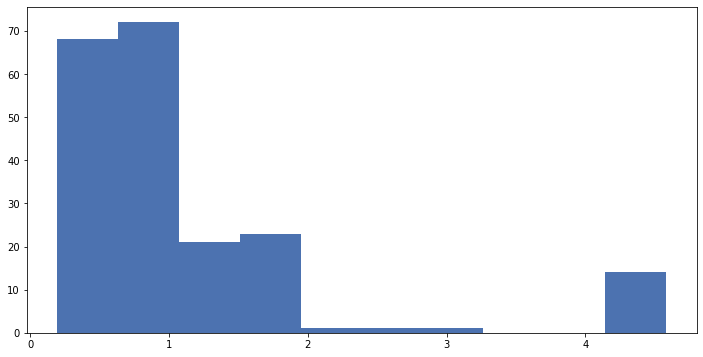

In [38]:
#Reconstruction error with fraud

fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1.0]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [39]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

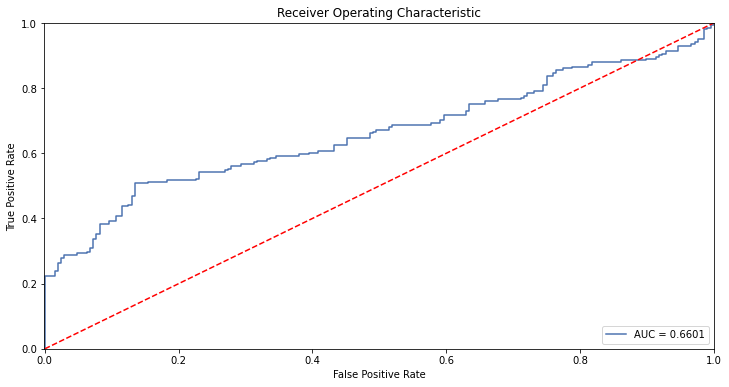

In [40]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

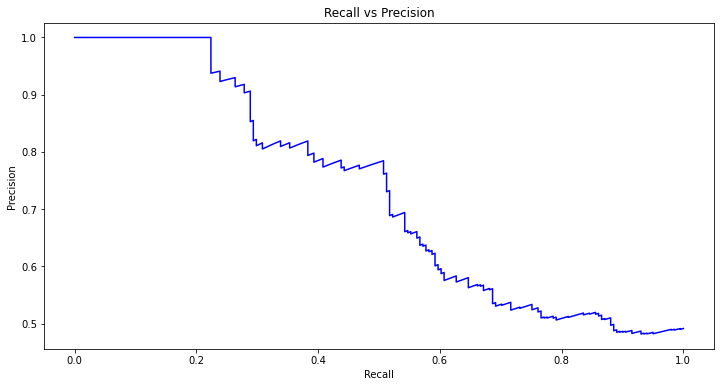

In [41]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

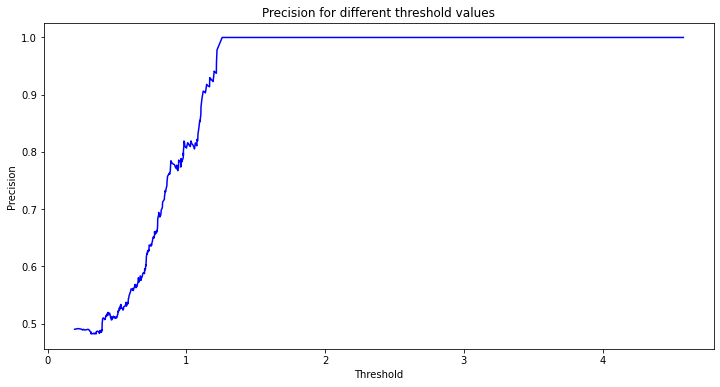

In [42]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

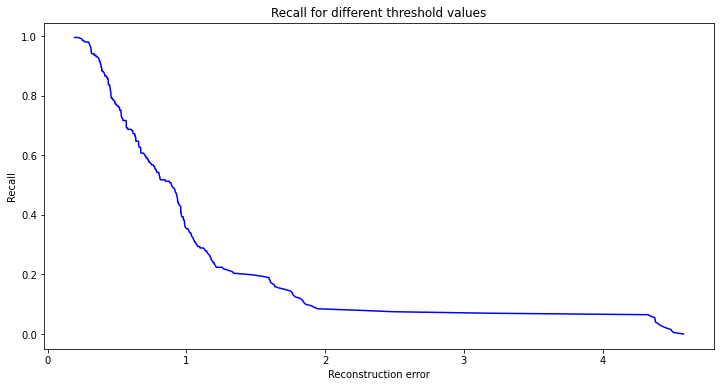

In [43]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()